# Forecasting
In this lesson, we will practice forecasting using the following methods:
- Last observed value
- Simple average
- Moving average
- Holt's Linear Trend
- Previous cycle
***
We will walk through steps from previous lessons to get the data ready to model
- Acquire data: prepare.acquire_store_data()
- Prepare data: prepare.prep_store_data()
- Split data: prepare.split_store_data()

Then we will forecast and evaluate using each method.

In [5]:
# imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt 
from prepare import stores_sales_items_complete
from prepare import prep_all_data

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

In [6]:
# importing all data 
df1 = stores_sales_items_complete()

# prepping data
df1 = prep_all_data(df1)

# making copy of DF to avoid having to re-run functions above since they take a few minutes
df = df1.copy()

# previewing data
df.head()

,item,sale_amount,sale_id,store,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,day_week,month,sales_total
sale_date,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1,13.0,1,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,Tuesday,January,10.92
2013-01-01 00:00:00+00:00,12,26.0,211817,7,12018 Perrin Beitel Rd,San Antonio,7,TX,78217,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,Tuesday,January,218.40
2013-01-01 00:00:00+00:00,46,27.0,832657,7,12018 Perrin Beitel Rd,San Antonio,7,TX,78217,Mama Marys,46,Pizza Sauce,4.65,35457770664,35457770664,Tuesday,January,125.55
2013-01-01 00:00:00+00:00,12,54.0,213643,8,15000 San Pedro Ave,San Antonio,8,TX,78232,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,Tuesday,January,453.60
2013-01-01 00:00:00+00:00,12,35.0,215469,9,735 SW Military Dr,San Antonio,9,TX,78221,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,Tuesday,January,294.00


We will resample to daily, but essentially what we are doing is grouping by the day and aggregating using sum. The original granularity is daily, but there are multiple records of the same days across multiple stores.

In [7]:
def prep_data(df):
    return (df.assign(ds = pd.to_datetime(df.index)).
            # sort values by date
            sort_values('ds').
            # create dollars_sold column
            assign(dollars_sold = df.sale_amount * df.item_price).
            # sale_amount to be items_sold
            assign(items_sold = df.sale_amount).
            # aggregate daily by summing the values
            groupby(['ds'])[['dollars_sold', 'items_sold']].sum().
            # set index to date
            reset_index().set_index('ds')
           )

In [8]:
# using function on dataframe to prepare for forecasting
df = prep_data(df)

# removing time portion of datetime format
df.index = df.index.date

# previewing data
df.head()

,dollars_sold,items_sold
2013-01-01,73844.01,13696.0
2013-01-02,73570.58,13678.0
2013-01-03,78169.48,14488.0
2013-01-04,84467.73,15677.0
2013-01-05,87621.85,16237.0


In [9]:
# remove leap days
df = df[df.index != '2016-02-29']

### Split
1) We will use the training proportion method to split.

2) Identify the total length of the dataframe and multiply by train_prop to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data. (x = train_prop * 100)

3) Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.

4) Return train and test dataframes.

In [10]:
train_size = int(len(df) * .5)
train_size

913

In [11]:
validate_size = int(len(df) * .3)
validate_size

547

In [12]:
test_size = int(len(df) - train_size - validate_size)
test_size

366

In [13]:
validate_end_index = train_size + validate_size
validate_end_index

1460

In [14]:
# using values above to split our data
train = df[: train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

#### Verify our splits are sound

In [15]:
# Does the length of each df equate to the length of the original df?
print(len(train) + len(validate) + len(test) == len(df))

True


In [16]:
# Does the first row of original df equate to the first row of train?
print(df.head(1) == train.head(1))

            dollars_sold  items_sold
2013-01-01          True        True


In [17]:
# Is the last row of train the day before the first row of validate? And the same for validate to test?
pd.concat([train.tail(1), validate.head(1)])

,dollars_sold,items_sold
2015-07-02,178036.64,33134.0
2015-07-03,190981.55,35498.0


In [18]:
pd.concat([validate.tail(1), test.head(1)])

,dollars_sold,items_sold
2016-12-30,120033.64,22296.0
2016-12-31,128009.31,23792.0


In [19]:
# Is the last row of test the same as the last row of our original dataframe?
pd.concat([test.tail(1), df.tail(1)])

,dollars_sold,items_sold
2017-12-31,140905.74,26420.0
2017-12-31,140905.74,26420.0


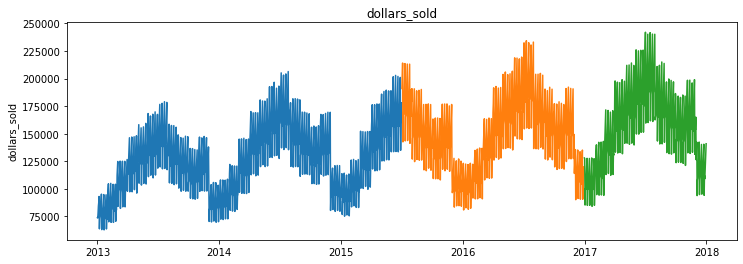

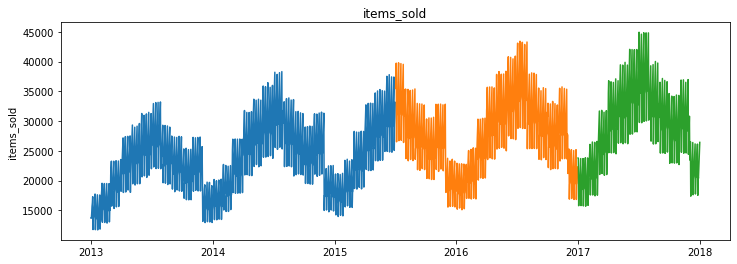

In [20]:
# Let's plot our data first, viewing where the data is split into train and test.

for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow.


evaluate() will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.

In [21]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

plot_and_eval() will use the evaluate function and also plot train and test values with the predicted values in order to compare performance.

In [22]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

Write append_eval_df(model_type) to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our eval_df data frame object. 

Which we will create an empty eval_df dataframe object to start.

In [23]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [24]:
eval_df

,model_type,target_var,rmse


## Forecast
Forecasting is another word for predicting time series data.

1) Last Observed Value

2) Simple Average

3) Moving Average

4) Holt's Linear Trend

5) Previous Cycle

### Last observed value
The simplest method for forecasting is to predict all future values to be the last observed value.
#### Make Predictions
Dollars

In [25]:
dollars = round(train['dollars_sold'][-1:][0], 2)
dollars

178036.64

In [26]:
items = train['items_sold'][-1:][0]
items

33134.0

In [27]:
yhat_df = pd.DataFrame({'dollars_sold': [dollars], 
                        'items_sold': [items]}, 
                      index = validate.index)

yhat_df.head()
yhat_df.describe()

,dollars_sold,items_sold
count,5.470000e+02,547.0
mean,1.780366e+05,33134.0
std,4.952180e-10,0.0
min,1.780366e+05,33134.0
25%,1.780366e+05,33134.0
50%,1.780366e+05,33134.0
75%,1.780366e+05,33134.0
max,1.780366e+05,33134.0


You can see, when peeking into yhat_df, that every predicted value is the same.
#### Plot Actual vs. Predicted Values
Now, let's plot actual and predicted values

dollars_sold -- RMSE: 42791


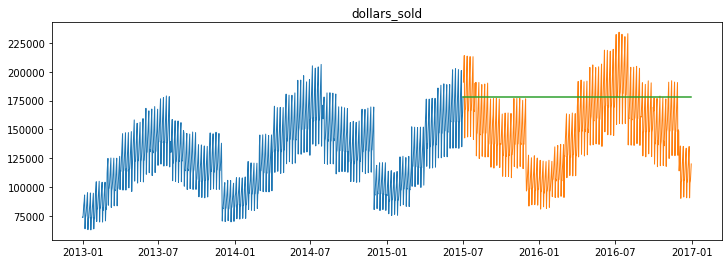

In [28]:
plot_and_eval('dollars_sold')

dollars_sold -- RMSE: 42791


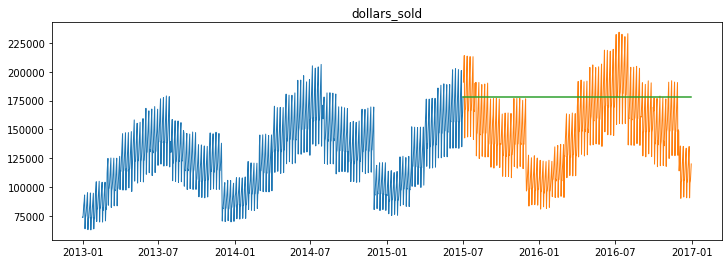

items_sold -- RMSE: 7970


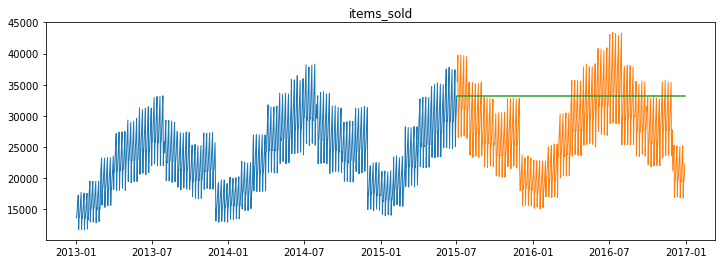

In [29]:
for col in train.columns:
    plot_and_eval(col)

#### Evaluate

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df

In [30]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,42791.0
1,last_observed_value,items_sold,7970.0


### Simple Average
Take the simple average of historical values and use that value to predict future values.

This is a good option for an initial baseline. 

Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train.

#### Make Predictions
Dollars: establishing the value of the prediction we will make

In [31]:
# compute simple average

# plt.plot(train['dollars_sold'])
dollars = round(train['dollars_sold'].mean(),2)
dollars

127573.19

Items: establishing the value of the prediction we will make

In [32]:
items = round(train['items_sold'].mean(),2)
items

23728.25

Apply predictions to our observations

In [33]:
def make_predictions():
    yhat_df = pd.DataFrame({'dollars_sold': [dollars],
                           'items_sold': [items]}, 
                           index = validate.index)
    return yhat_df

In [34]:
yhat_df = make_predictions()

In [35]:
yhat_df.head()

,dollars_sold,items_sold
2015-07-03,127573.19,23728.25
2015-07-04,127573.19,23728.25
2015-07-05,127573.19,23728.25
2015-07-06,127573.19,23728.25
2015-07-07,127573.19,23728.25


In [36]:
yhat_df.describe()

,dollars_sold,items_sold
count,5.470000e+02,547.00
mean,1.275732e+05,23728.25
std,9.467403e-10,0.00
min,1.275732e+05,23728.25
25%,1.275732e+05,23728.25
50%,1.275732e+05,23728.25
75%,1.275732e+05,23728.25
max,1.275732e+05,23728.25


#### Plot Actual vs. Predicted Values

Now, let's plot and evaluate the performance of our time series model using Simple Average

dollars_sold -- RMSE: 39605


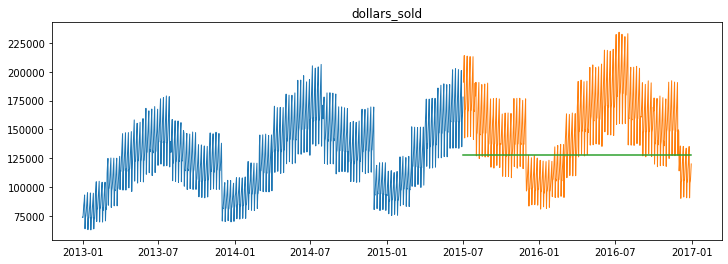

items_sold -- RMSE: 7367


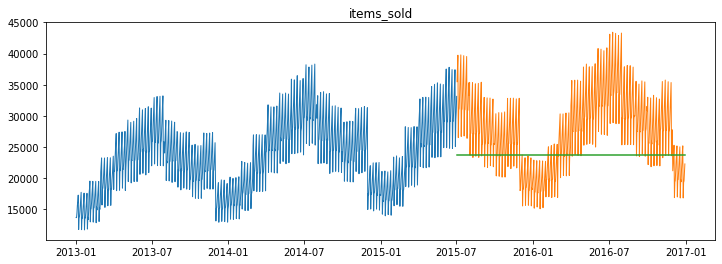

In [37]:
for col in train.columns:
    plot_and_eval(col)

#### Evaluate

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df

In [38]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,42791.0
1,last_observed_value,items_sold,7970.0
2,simple_average,dollars_sold,39605.0
3,simple_average,items_sold,7367.0


### Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value.

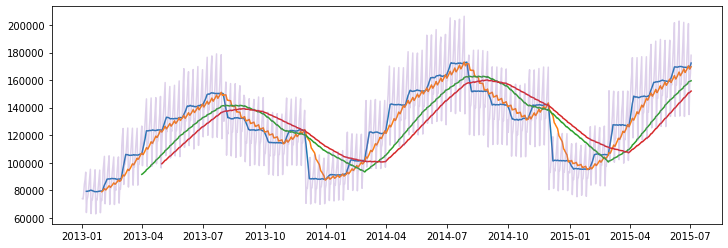

In [39]:
# train['dollars_sold'].tail(30)
plt.figure(figsize=(12,4))
plt.plot(train['dollars_sold'].rolling(7).mean())
plt.plot(train['dollars_sold'].rolling(30).mean())
plt.plot(train['dollars_sold'].rolling(90).mean())
plt.plot(train['dollars_sold'].rolling(120).mean())
plt.plot(train['dollars_sold'], alpha=.3)

In [40]:
# demonstrate that the mean of the first 30 days 
# is equal to rolling(30) on day 30

print(train['dollars_sold'].rolling(30).mean()[29])
print(train['dollars_sold'].head(30).mean())

78937.69766666666
78937.69766666666


#### Make predictions

In [41]:
period = 30 

dollars = round(train['dollars_sold'].rolling(period).mean()[-1], 2)
items = round(train['items_sold'].rolling(period).mean()[-1], 2)

print(dollars, items)

169649.38 31561.9


In [42]:
yhat_df = make_predictions()
yhat_df.head()

,dollars_sold,items_sold
2015-07-03,169649.38,31561.9
2015-07-04,169649.38,31561.9
2015-07-05,169649.38,31561.9
2015-07-06,169649.38,31561.9
2015-07-07,169649.38,31561.9


#### Plot Actual vs. Predicted Values
Now, let's plot and evaluate the performance of our time series model using Moving Average

dollars_sold -- RMSE: 37875


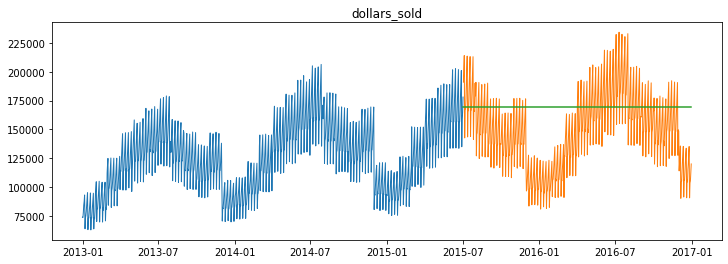

items_sold -- RMSE: 7047


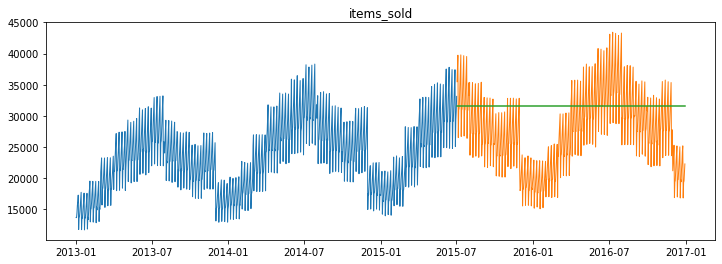

In [43]:
for col in train.columns:
    plot_and_eval(col)

### Evaluate
Evaluate using MSE and RMSE, and add evaluation metrics to eval_df

In [44]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,42791.0
1,last_observed_value,items_sold,7970.0
2,simple_average,dollars_sold,39605.0
3,simple_average,items_sold,7367.0
4,30d_moving_avg,dollars_sold,37875.0
5,30d_moving_avg,items_sold,7047.0


Let's try out several other values for periods:

In [45]:
periods = [4, 12, 26, 52, 104]

for p in periods: 
    dollars = round(train['dollars_sold'].rolling(p).mean()[-1], 2)
    items = round(train['items_sold'].rolling(p).mean()[-1],2)
    yhat_df = make_predictions()
    model_type = str(p) + 'd_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = col)

In [46]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,42791.0
1,last_observed_value,items_sold,7970.0
2,simple_average,dollars_sold,39605.0
3,simple_average,items_sold,7367.0
4,30d_moving_avg,dollars_sold,37875.0
5,30d_moving_avg,items_sold,7047.0
6,4d_moving_avg,dollars_sold,33701.0
7,4d_moving_avg,items_sold,6259.0
8,12d_moving_avg,dollars_sold,37291.0
9,12d_moving_avg,items_sold,6928.0


Which is best so far?

In [47]:
min_items_rmse = eval_df[eval_df.target_var == 'items_sold']['rmse'].min()

eval_df[eval_df.rmse == min_items_rmse]

,model_type,target_var,rmse
15,104d_moving_avg,items_sold,6132.0


### Holt's Linear Trend
Exponential smoothing applied to both the average and the trend (slope).


$\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.


$\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values.
#### Seasonal Decomposition
First, let's take a look at the seasonal decomposition for each target.

In [60]:
trainsdeco = train.copy()

dollars_sold 



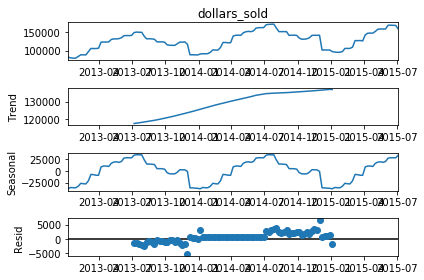

items_sold 



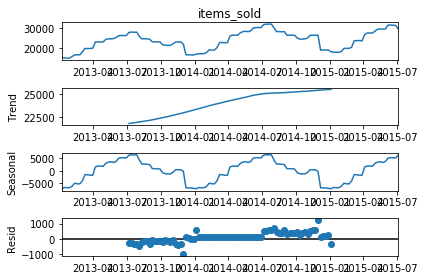

In [62]:
trainsdeco.index = pd.to_datetime(trainsdeco.index)

for col in trainsdeco.columns:
    print(col, '\n')
    sm.tsa.seasonal_decompose(trainsdeco[col].resample('W').mean()).plot()
    plt.show()

#### Basic Holt's Linear Trend
#### Make Predictions

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions.

Holt:
exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)
damped $\phi$ = True/False: with Holt, forecasts will increase or decrease indefinitely into the future. To avoid this, use the Damped trend method which has a damping parameter 0< ϕ <1.

fit:
smoothing_level ($\alpha$): value between (0,1)
smoothing_slope ($\beta$): value between (0,1)
optimized: use the auto-optimization that allow statsmodels to automatically find an optimized value for us.

In [49]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

In [50]:
yhat_df.head()

,dollars_sold,items_sold
2015-07-03,170302.36,31672.82
2015-07-04,170325.13,31676.37
2015-07-05,170346.78,31679.76
2015-07-06,170367.37,31682.97
2015-07-07,170386.93,31686.01


#### Plot Actual vs. Predicted Values

dollars_sold -- RMSE: 38462


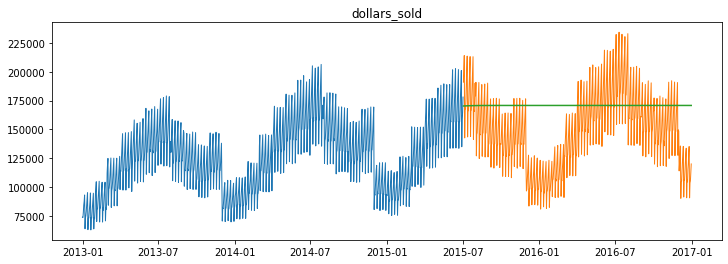

items_sold -- RMSE: 7142


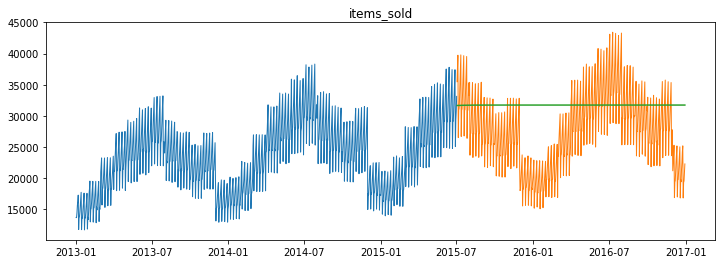

In [51]:
for col in train.columns:
    plot_and_eval(target_var = col)

#### evaluate

In [52]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [53]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
15,104d_moving_avg,items_sold,6132.0
7,4d_moving_avg,items_sold,6259.0
13,52d_moving_avg,items_sold,6666.0
9,12d_moving_avg,items_sold,6928.0
11,26d_moving_avg,items_sold,6989.0
5,30d_moving_avg,items_sold,7047.0
17,holts_optimized,items_sold,7142.0
3,simple_average,items_sold,7367.0
1,last_observed_value,items_sold,7970.0
14,104d_moving_avg,dollars_sold,32967.0


In [54]:
# alternate model with hyper parameters
for col in train.columns:
    model = Holt(train[col], exponential=False)
    model = model.fit(smoothing_level=.1, 
                      smoothing_slope=.1, 
                      optimized=False)
    yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

dollars_sold -- RMSE: 42832


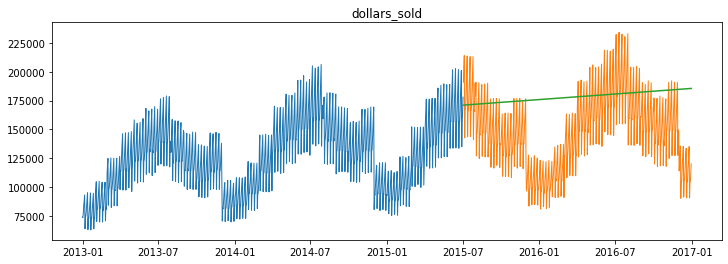

items_sold -- RMSE: 7854


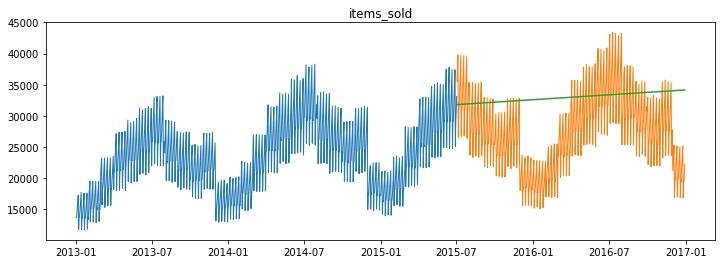

In [55]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [63]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_.1', 
                            target_var = col)
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
15,104d_moving_avg,items_sold,6132.0
7,4d_moving_avg,items_sold,6259.0
13,52d_moving_avg,items_sold,6666.0
9,12d_moving_avg,items_sold,6928.0
11,26d_moving_avg,items_sold,6989.0
5,30d_moving_avg,items_sold,7047.0
17,holts_optimized,items_sold,7142.0
3,simple_average,items_sold,7367.0
19,holts_.1,items_sold,7854.0
1,last_observed_value,items_sold,7970.0


#### Predict Based on Previous Cycle
- Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day.
- If a primary cycle is weekly, then you may want to do this on a week-over-week cadence.

In the below example:
- Compute the 365 average year over year differences from 2013 through 2015
- Add that average delta to the values during 2015.
- Set the index in your yhat dataframe to represent the dates those predictions are make for.

In [65]:
# resplit data

# setting index back to datetime to allow functions below to work
df.index = pd.to_datetime(df.index)

# giving one year of data to test and validate and 3 years to train
train = df[:'2015']
validate = df['2016']
test = df['2017']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()

(1095, 2)
(366, 2)
(365, 2)


,dollars_sold,items_sold
2013-01-01,73844.01,13696.0
2013-01-02,73570.58,13678.0
2013-01-03,78169.48,14488.0
2013-01-04,84467.73,15677.0
2013-01-05,87621.85,16237.0


In [66]:
# make predictions

# finding the year-over-year difference for each day from 2013 to 2015
# taking the mean, and then adding that value to the daily 2015 values. 

yhat_df = train['2015'] + train.diff(365).mean()

In [67]:
# let's peek into the prediction we will make for 1/1/2016
# by comparing the predicted value 
# (2015 value + year-over-year average difference)
# to the actual 1/1/2016 value
pd.concat([yhat_df.head(1), validate.head(1)])

,dollars_sold,items_sold
2015-01-01,104337.620493,19411.813699
2016-01-01,107875.260000,20158.000000


In [74]:
# dropping last row of validate because it has 1 more row than yhat
validate.drop(validate.tail(1).index,inplace=True)

# set yhat_df to index of validate
yhat_df.index = validate.index

yhat_df.describe()

,dollars_sold,items_sold
count,365.000000,365.000000
mean,152236.991370,28314.271233
std,31264.033981,5816.407123
min,87009.270493,16153.813699
25%,128679.520493,23977.813699
50%,150024.320493,27913.813699
75%,177535.990493,33022.813699
max,225791.620493,41979.813699


dollars_sold -- RMSE: 25201


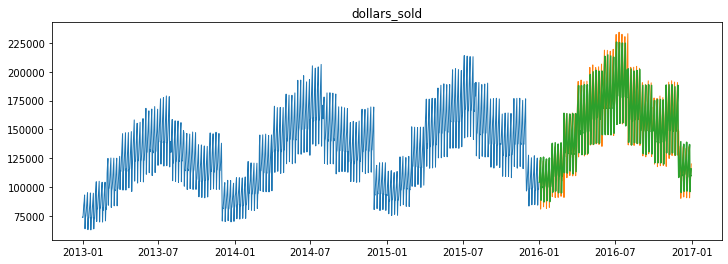

items_sold -- RMSE: 4691


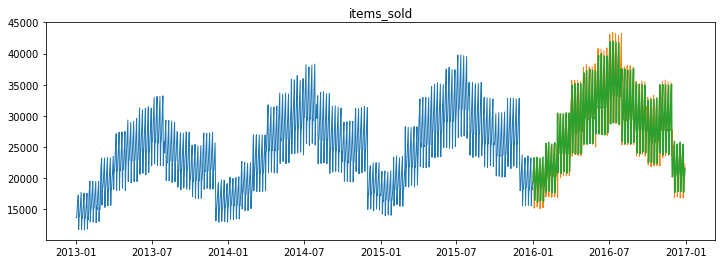

In [75]:
# plot and evaluate
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

In [76]:
# conclusion - which model performed the best

dollars_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

items_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == dollars_min_rmse) | 
         (eval_df.rmse == items_min_rmse))]

,model_type,target_var,rmse
20,previous_year,dollars_sold,25201.0
21,previous_year,items_sold,4691.0


Let's test it out on our out-of-sample data

We will be using train + validate to predict test.

In [77]:
yhat_df = validate + train.diff(365).mean()
yhat_df.index = test.index

In [78]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [79]:
rmse_dollars = sqrt(mean_squared_error(test['dollars_sold'], 
                                       yhat_df['dollars_sold']))

rmse_items = sqrt(mean_squared_error(test['items_sold'], 
                                       yhat_df['items_sold']))

In [80]:
print('rmse-dollars_sold: ', rmse_dollars)
print('rmse-items_sold: ', rmse_items)

rmse-dollars_sold:  30695.158024533957
rmse-items_sold:  5711.598728847905


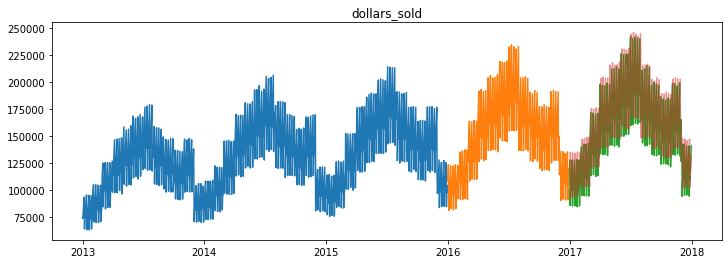

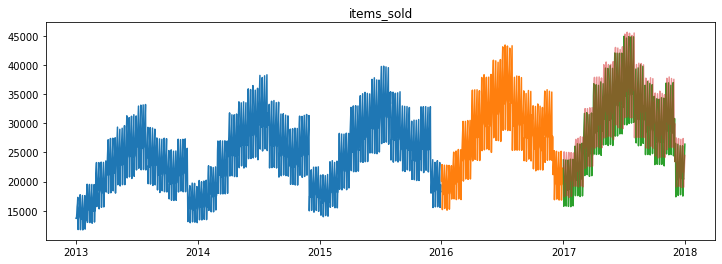

In [81]:
for col in train.columns:
    final_plot(col)

In [82]:
# to predict 2018

yhat_df = test + train.diff(365).mean()

yhat_df.index = test.index + pd.Timedelta('1Y')

In [83]:
yhat_df.head()

,dollars_sold,items_sold
2018-01-01 05:49:12,139013.960493,25894.813699
2018-01-02 05:49:12,97081.230493,17957.813699
2018-01-03 05:49:12,112140.900493,20835.813699
2018-01-04 05:49:12,111205.840493,20695.813699
2018-01-05 05:49:12,119365.050493,22080.813699


In [84]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

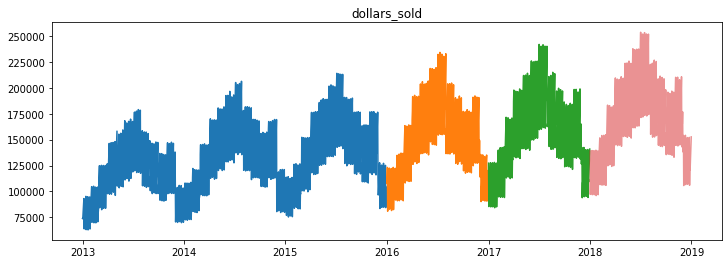

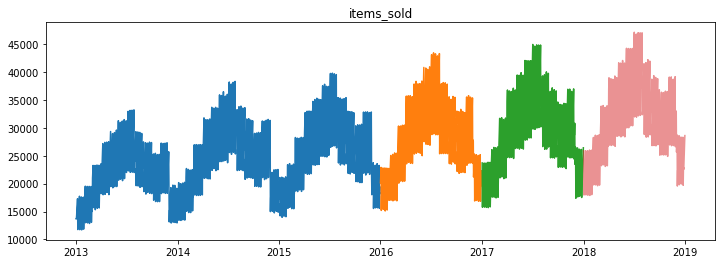

In [85]:
for col in train.columns:
    final_plot(col)